### Importing Packages

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import zipfile

import tensorflow as tf

In [2]:
import math

In [3]:
import itertools

In [4]:
from sklearn.metrics import classification_report, confusion_matrix

### Custom Defined Functions

In [5]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

In [6]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

#### Setting TF.Keras backend and TF.Session to be same for later conversion into SavedModel format

In [7]:
tf.keras.backend.set_session = tf.Session()

### Defining Directory for dataset

In [8]:
base_dir = './data/Two_Notes_Modelling' # example: /datasets/cash_recog_data/
train_dir = os.path.join(base_dir, 'train') 
validation_dir = os.path.join(base_dir, 'test')

In [9]:
checkpoint_path = "checkpoints/Two_Notes_Modelling/model100-lr0001-drp03_v4/training.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create checkpoint callback/
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
                                                 save_weights_only=True,
                                                 verbose=1,
                                                 save_freq=5)

### Setting up batch size, epochs and image size to be resized into

In [10]:
batch_size = 64
epochs = 100
IMG_SHAPE = 224 # Our training data will consists of images with width of 224 pixels and height of 224 pixels

### Downloading the pre-trained model

In [11]:
pre_model = tf.keras.applications.mobilenet_v2.MobileNetV2(input_shape=(224,224,3), alpha=1.0, include_top=False, weights='imagenet')

W0830 16:15:06.814635 140066482308928 deprecation.py:506] From /home/aqsa/Desktop/AI projects Tensorflow/tensorflow-projects/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


### Setting the layers of pre-trained model to be non trainable for transfer learning

In [12]:
for layer in pre_model.layers:
    layer.trainable = False

### Setting up Data Generators

In [13]:
train_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
                    rescale=1./255, 
                    rotation_range=45, 
                    width_shift_range=.15, 
                    height_shift_range=.15, 
                    horizontal_flip=True, 
                    zoom_range=0.2
                    )

validation_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [14]:
train_data_gen = train_image_generator.flow_from_directory(
                                                batch_size=batch_size, 
                                                directory=train_dir, 
                                                shuffle=True, 
                                                class_mode='categorical',
                                                target_size=(IMG_SHAPE,IMG_SHAPE))

Found 402 images belonging to 2 classes.


In [15]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size=16, 
                                                              directory=validation_dir, 
                                                              class_mode='categorical',
                                                              target_size=(IMG_SHAPE,IMG_SHAPE),shuffle=False)

Found 59 images belonging to 2 classes.


In [16]:
sample_training_images, _ = next(train_data_gen) 

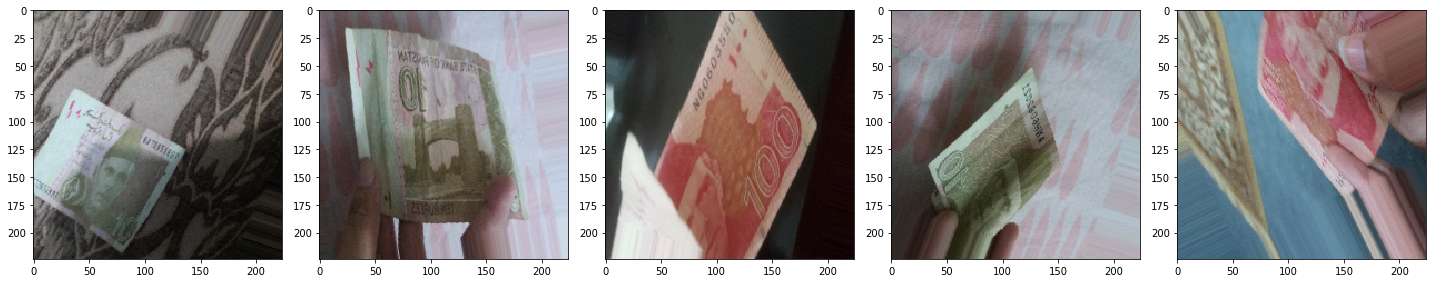

In [17]:
plotImages(sample_training_images[:5])

### Constructing the model

In [18]:
model_fine = tf.keras.models.Sequential()

In [19]:
model_fine.add(pre_model)

In [20]:
model_fine.add(tf.keras.layers.Flatten())

In [21]:
model_fine.add(tf.keras.layers.Dense(64, activation='relu'))
model_fine.add(tf.keras.layers.Dropout(0.3))
model_fine.add(tf.keras.layers.Dense(32, activation='relu'))

In [22]:
model_fine.add(tf.keras.layers.Dense(2, activation='softmax'))

In [23]:
model_fine.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
flatten (Flatten)            (None, 62720)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                4014144   
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 66        
Total params: 6,274,274
Trainable params: 4,016,290
Non-trainable params: 2,257,984
______________________________________

### Compiling the model

In [24]:
model_fine.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['categorical_accuracy'])

### Training process

In [25]:
history = model_fine.fit_generator(train_data_gen, validation_data=val_data_gen, epochs=100, steps_per_epoch=6, validation_steps=4, callbacks=[cp_callback])

Epoch 1/100

Epoch 00001: saving model to checkpoints/Two_Notes_Modelling/model100-lr0001-drp03_v4/training.ckpt
1/6 [====>.........................] - ETA: 1:37 - loss: 1.7192 - categorical_accuracy: 0.4844
Epoch 00001: saving model to checkpoints/Two_Notes_Modelling/model100-lr0001-drp03_v4/training.ckpt
2/6 [=========>....................] - ETA: 59s - loss: 1.5239 - categorical_accuracy: 0.4688 
Epoch 00001: saving model to checkpoints/Two_Notes_Modelling/model100-lr0001-drp03_v4/training.ckpt
3/6 [==============>...............] - ETA: 45s - loss: 1.3724 - categorical_accuracy: 0.4792
Epoch 00001: saving model to checkpoints/Two_Notes_Modelling/model100-lr0001-drp03_v4/training.ckpt
4/6 [===================>..........] - ETA: 29s - loss: 1.2539 - categorical_accuracy: 0.4648
Epoch 00001: saving model to checkpoints/Two_Notes_Modelling/model100-lr0001-drp03_v4/training.ckpt
5/6 [========================>.....] - ETA: 14s - loss: 1.1527 - categorical_accuracy: 0.4875
Epoch 00001: sa

2/6 [=========>....................] - ETA: 40s - loss: 0.1434 - categorical_accuracy: 0.9453
Epoch 00014: saving model to checkpoints/Two_Notes_Modelling/model100-lr0001-drp03_v4/training.ckpt
3/6 [==============>...............] - ETA: 32s - loss: 0.1370 - categorical_accuracy: 0.9583
Epoch 00014: saving model to checkpoints/Two_Notes_Modelling/model100-lr0001-drp03_v4/training.ckpt
4/6 [===================>..........] - ETA: 22s - loss: 0.1549 - categorical_accuracy: 0.9492
Epoch 00014: saving model to checkpoints/Two_Notes_Modelling/model100-lr0001-drp03_v4/training.ckpt
5/6 [========================>.....] - ETA: 11s - loss: 0.1725 - categorical_accuracy: 0.9438
Epoch 00014: saving model to checkpoints/Two_Notes_Modelling/model100-lr0001-drp03_v4/training.ckpt
6/6 [==============================] - 83s 14s/step - loss: 0.1606 - categorical_accuracy: 0.9479 - val_loss: 0.3257 - val_categorical_accuracy: 0.8305
Epoch 15/100

Epoch 00015: saving model to checkpoints/Two_Notes_Modelli

Epoch 21/100

Epoch 00021: saving model to checkpoints/Two_Notes_Modelling/model100-lr0001-drp03_v4/training.ckpt
1/6 [====>.........................] - ETA: 34s - loss: 0.1014 - categorical_accuracy: 0.9688
Epoch 00021: saving model to checkpoints/Two_Notes_Modelling/model100-lr0001-drp03_v4/training.ckpt
2/6 [=========>....................] - ETA: 36s - loss: 0.1311 - categorical_accuracy: 0.9453
Epoch 00021: saving model to checkpoints/Two_Notes_Modelling/model100-lr0001-drp03_v4/training.ckpt
3/6 [==============>...............] - ETA: 32s - loss: 0.1162 - categorical_accuracy: 0.9531
Epoch 00021: saving model to checkpoints/Two_Notes_Modelling/model100-lr0001-drp03_v4/training.ckpt
4/6 [===================>..........] - ETA: 22s - loss: 0.1065 - categorical_accuracy: 0.9570
Epoch 00021: saving model to checkpoints/Two_Notes_Modelling/model100-lr0001-drp03_v4/training.ckpt
5/6 [========================>.....] - ETA: 9s - loss: 0.0927 - categorical_accuracy: 0.9599 
Epoch 00021: sav

2/6 [=========>....................] - ETA: 17s - loss: 0.1469 - categorical_accuracy: 0.9390
Epoch 00034: saving model to checkpoints/Two_Notes_Modelling/model100-lr0001-drp03_v4/training.ckpt
3/6 [==============>...............] - ETA: 21s - loss: 0.1584 - categorical_accuracy: 0.9452
Epoch 00034: saving model to checkpoints/Two_Notes_Modelling/model100-lr0001-drp03_v4/training.ckpt
4/6 [===================>..........] - ETA: 17s - loss: 0.1350 - categorical_accuracy: 0.9476
Epoch 00034: saving model to checkpoints/Two_Notes_Modelling/model100-lr0001-drp03_v4/training.ckpt
5/6 [========================>.....] - ETA: 9s - loss: 0.1399 - categorical_accuracy: 0.9489 
Epoch 00034: saving model to checkpoints/Two_Notes_Modelling/model100-lr0001-drp03_v4/training.ckpt
6/6 [==============================] - 77s 13s/step - loss: 0.1343 - categorical_accuracy: 0.9497 - val_loss: 0.2579 - val_categorical_accuracy: 0.9322
Epoch 35/100

Epoch 00035: saving model to checkpoints/Two_Notes_Modelli

Epoch 41/100

Epoch 00041: saving model to checkpoints/Two_Notes_Modelling/model100-lr0001-drp03_v4/training.ckpt
1/6 [====>.........................] - ETA: 38s - loss: 0.0479 - categorical_accuracy: 0.9844
Epoch 00041: saving model to checkpoints/Two_Notes_Modelling/model100-lr0001-drp03_v4/training.ckpt
2/6 [=========>....................] - ETA: 34s - loss: 0.0437 - categorical_accuracy: 0.9844
Epoch 00041: saving model to checkpoints/Two_Notes_Modelling/model100-lr0001-drp03_v4/training.ckpt
3/6 [==============>...............] - ETA: 19s - loss: 0.0481 - categorical_accuracy: 0.9863
Epoch 00041: saving model to checkpoints/Two_Notes_Modelling/model100-lr0001-drp03_v4/training.ckpt
4/6 [===================>..........] - ETA: 17s - loss: 0.0525 - categorical_accuracy: 0.9810
Epoch 00041: saving model to checkpoints/Two_Notes_Modelling/model100-lr0001-drp03_v4/training.ckpt
5/6 [========================>.....] - ETA: 9s - loss: 0.0723 - categorical_accuracy: 0.9745 
Epoch 00041: sav

2/6 [=========>....................] - ETA: 17s - loss: 0.2081 - categorical_accuracy: 0.9146
Epoch 00054: saving model to checkpoints/Two_Notes_Modelling/model100-lr0001-drp03_v4/training.ckpt
3/6 [==============>...............] - ETA: 20s - loss: 0.1501 - categorical_accuracy: 0.9521
Epoch 00054: saving model to checkpoints/Two_Notes_Modelling/model100-lr0001-drp03_v4/training.ckpt
4/6 [===================>..........] - ETA: 16s - loss: 0.1342 - categorical_accuracy: 0.9476
Epoch 00054: saving model to checkpoints/Two_Notes_Modelling/model100-lr0001-drp03_v4/training.ckpt
5/6 [========================>.....] - ETA: 9s - loss: 0.1136 - categorical_accuracy: 0.9599 
Epoch 00054: saving model to checkpoints/Two_Notes_Modelling/model100-lr0001-drp03_v4/training.ckpt
6/6 [==============================] - 72s 12s/step - loss: 0.1069 - categorical_accuracy: 0.9586 - val_loss: 0.2389 - val_categorical_accuracy: 0.9492
Epoch 55/100

Epoch 00055: saving model to checkpoints/Two_Notes_Modelli

Epoch 61/100

Epoch 00061: saving model to checkpoints/Two_Notes_Modelling/model100-lr0001-drp03_v4/training.ckpt
1/6 [====>.........................] - ETA: 10s - loss: 0.1239 - categorical_accuracy: 0.9444
Epoch 00061: saving model to checkpoints/Two_Notes_Modelling/model100-lr0001-drp03_v4/training.ckpt
2/6 [=========>....................] - ETA: 16s - loss: 0.0740 - categorical_accuracy: 0.9878
Epoch 00061: saving model to checkpoints/Two_Notes_Modelling/model100-lr0001-drp03_v4/training.ckpt
3/6 [==============>...............] - ETA: 21s - loss: 0.0985 - categorical_accuracy: 0.9863
Epoch 00061: saving model to checkpoints/Two_Notes_Modelling/model100-lr0001-drp03_v4/training.ckpt
4/6 [===================>..........] - ETA: 17s - loss: 0.0857 - categorical_accuracy: 0.9857
Epoch 00061: saving model to checkpoints/Two_Notes_Modelling/model100-lr0001-drp03_v4/training.ckpt
5/6 [========================>.....] - ETA: 9s - loss: 0.0851 - categorical_accuracy: 0.9818 
Epoch 00061: sav

2/6 [=========>....................] - ETA: 15s - loss: 0.1504 - categorical_accuracy: 0.9512
Epoch 00074: saving model to checkpoints/Two_Notes_Modelling/model100-lr0001-drp03_v4/training.ckpt
3/6 [==============>...............] - ETA: 19s - loss: 0.1595 - categorical_accuracy: 0.9384
Epoch 00074: saving model to checkpoints/Two_Notes_Modelling/model100-lr0001-drp03_v4/training.ckpt
4/6 [===================>..........] - ETA: 16s - loss: 0.1347 - categorical_accuracy: 0.9476
Epoch 00074: saving model to checkpoints/Two_Notes_Modelling/model100-lr0001-drp03_v4/training.ckpt
5/6 [========================>.....] - ETA: 9s - loss: 0.1216 - categorical_accuracy: 0.9562 
Epoch 00074: saving model to checkpoints/Two_Notes_Modelling/model100-lr0001-drp03_v4/training.ckpt
6/6 [==============================] - 61s 10s/step - loss: 0.1081 - categorical_accuracy: 0.9589 - val_loss: 0.2757 - val_categorical_accuracy: 0.9153
Epoch 75/100

Epoch 00075: saving model to checkpoints/Two_Notes_Modelli

Epoch 81/100

Epoch 00081: saving model to checkpoints/Two_Notes_Modelling/model100-lr0001-drp03_v4/training.ckpt
1/6 [====>.........................] - ETA: 30s - loss: 0.0322 - categorical_accuracy: 1.0000
Epoch 00081: saving model to checkpoints/Two_Notes_Modelling/model100-lr0001-drp03_v4/training.ckpt
2/6 [=========>....................] - ETA: 33s - loss: 0.0441 - categorical_accuracy: 0.9766
Epoch 00081: saving model to checkpoints/Two_Notes_Modelling/model100-lr0001-drp03_v4/training.ckpt
3/6 [==============>...............] - ETA: 29s - loss: 0.0596 - categorical_accuracy: 0.9688
Epoch 00081: saving model to checkpoints/Two_Notes_Modelling/model100-lr0001-drp03_v4/training.ckpt
4/6 [===================>..........] - ETA: 15s - loss: 0.0500 - categorical_accuracy: 0.9714
Epoch 00081: saving model to checkpoints/Two_Notes_Modelling/model100-lr0001-drp03_v4/training.ckpt
5/6 [========================>.....] - ETA: 9s - loss: 0.0518 - categorical_accuracy: 0.9708 
Epoch 00081: sav

2/6 [=========>....................] - ETA: 34s - loss: 0.0472 - categorical_accuracy: 0.9688
Epoch 00094: saving model to checkpoints/Two_Notes_Modelling/model100-lr0001-drp03_v4/training.ckpt
3/6 [==============>...............] - ETA: 30s - loss: 0.0840 - categorical_accuracy: 0.9583
Epoch 00094: saving model to checkpoints/Two_Notes_Modelling/model100-lr0001-drp03_v4/training.ckpt
4/6 [===================>..........] - ETA: 21s - loss: 0.0709 - categorical_accuracy: 0.9648
Epoch 00094: saving model to checkpoints/Two_Notes_Modelling/model100-lr0001-drp03_v4/training.ckpt
5/6 [========================>.....] - ETA: 10s - loss: 0.0871 - categorical_accuracy: 0.9563
Epoch 00094: saving model to checkpoints/Two_Notes_Modelling/model100-lr0001-drp03_v4/training.ckpt
6/6 [==============================] - 81s 13s/step - loss: 0.0778 - categorical_accuracy: 0.9635 - val_loss: 0.2294 - val_categorical_accuracy: 0.9153
Epoch 95/100

Epoch 00095: saving model to checkpoints/Two_Notes_Modelli

6/6 [==============================] - 73s 12s/step - loss: 0.0740 - categorical_accuracy: 0.9763 - val_loss: 0.1640 - val_categorical_accuracy: 0.9492


### Model evaluated on validation set

In [26]:
model_fine.evaluate_generator(val_data_gen)

[0.16398575669154525, 0.9491525]

### Plotting the training process

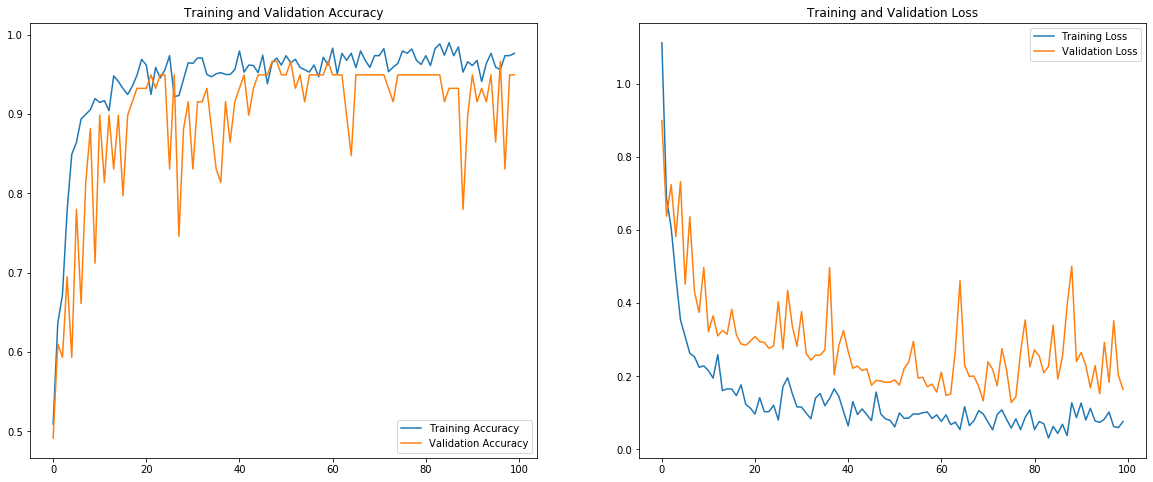

In [27]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(100)

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [28]:
model_fine.save("saved_models/Two_Notes_Modelling/CashKeras-100-transfer-epoch-drpt-03-lr0001.h5")

### Plotting the confusion matrix for classification evaluation

In [30]:
Y_pred = model_fine.predict_generator(val_data_gen)

In [31]:
y_pred = np.argmax(Y_pred, axis=1)

In [32]:
y_pred.shape

(59,)

In [33]:
print('Confusion Matrix')
print(confusion_matrix(val_data_gen.classes, y_pred))

Confusion Matrix
[[24  2]
 [ 1 32]]


In [34]:
cm = confusion_matrix(val_data_gen.classes, y_pred)

In [35]:
print('Classification Report')
target_names = ['hundred', 'ten']
print(classification_report(val_data_gen.classes, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

     hundred       0.96      0.92      0.94        26
         ten       0.94      0.97      0.96        33

    accuracy                           0.95        59
   macro avg       0.95      0.95      0.95        59
weighted avg       0.95      0.95      0.95        59



Confusion matrix, without normalization
[[24  2]
 [ 1 32]]
Normalized confusion matrix
[[0.92 0.08]
 [0.03 0.97]]


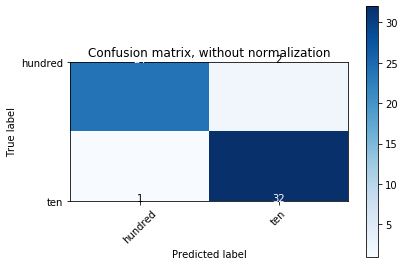

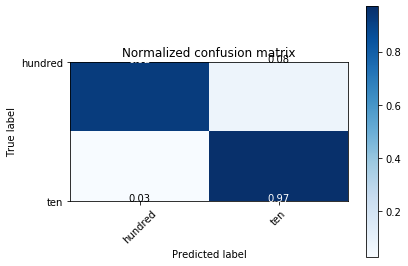

In [36]:
# Compute confusion matrix
cnf_matrix = cm
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=target_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=target_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()